# Stat-xplore statistics for Lewisham

Fetches labour market data

_This requires the `OA->LSOA` lookup table produced by `lbl_boundaries_oa.ipynb` as well as the `OA->WD22` lookup table produced by "`lbl_boundaries_2022_wards.ipynb`"_

# Setup

## Imports

In [1]:
%%capture
!pip install https://github.com/philipbrien/statxplorer/zipball/master
!pip install geopandas

In [ ]:
import statxplorer
key = "65794a30655841694f694a4b563151694c434a68624763694f694a49557a49314e694a392e65794a7063334d694f694a7a644849756333526c6247786863694973496e4e3159694936496d6c7563326c6e614851745957356b4c57526c62476c325a584a355147786c64326c7a614746744c6d64766469353161794973496d6c68644349364d54597a4e7a497a4d6a51344d5377695958566b496a6f69633352794c6d396b59534a392e764b6a5355767a594132314a374a6a5f31345076774f6243584a6178576a52303173634e68547238517863"
import json
explorer = statxplorer.StatXplorer(key)


In [ ]:
import os

import pandas as pd
import geopandas as gpd
import IPython
import matplotlib
import matplotlib.pyplot as plt

## Filesystem

In [ ]:
# Determine if in google colab
def in_colab():
    return True if os.getenv("HOME") == "/root" else False

In [ ]:
# Google Drive access
if in_colab():
    from google.colab import drive
    drive.mount("/content/gdrive")
    project_dir = "/content/gdrive/MyDrive/WardProfiles"
else:
    project_dir = "/Volumes/GoogleDrive/My Drive/WardProfiles"

print("project_dir:", project_dir)


Mounted at /content/gdrive
project_dir: /content/gdrive/MyDrive/WardProfiles


In [ ]:
oa_lookups_dir = f"{project_dir}/lookups/oa"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"

# For exports
output_dir = f"{project_dir}/job_seekers_allowance"

In [ ]:
!mkdir -p '{output_dir}'

In [ ]:
!ls '{output_dir}'

table_2021-12-07_20-55-25.json


[Dataset: Jobseekers Allowance (JSA)](https://stat-xplore.dwp.gov.uk/webapi/metadata/JSA/JSA.html)

```
 Dataset: Jobseekers Allowance (JSA)

Description

Jobseeker’s Allowance (JSA) is a working age benefit for people who are not in full time employment (work less than 16 hours per week) and are available for, and actively seeking, work. Income-based JSA is being replaced by Universal Credit (UC).

JSA is either contribution-based or income-based depending on the jobseeker’s circumstances:

    Contribution-based JSA: You can get contribution-based JSA if you’ve paid enough Class 1 National Insurance contributions. You can get this type of JSA even if your partner works or you have savings but you cannot claim contribution-based if you’ve never worked. ‘New style’ JSA is a type of contribution-based JSA which can be applied for if you live in a UC full service area – it can be claimed on its own or at the same time as UC.
    Income-based JSA: You may be eligible for income-based JSA if the following apply: you work less than 16 hours per week on average; your partner works less than 24 hours per week on average; you and your partner have £16,000 or less in savings between you. You cannot get income-based JSA and UC at the same time.

Recording and clerical errors can occur within the data source - for this reason, no reliance should be placed on very small numbers obtained through Stat-Xplore.

Statistical disclosure control has been applied with Stat-Xplore, which guards against the identification of an individual claimant. 
```

In [ ]:
def get_data(statxplore_table_config):
    query = f'{output_dir}/{statxplore_table_config}.json'
    results = explorer.fetch_table(query, reshape=False)
    data = results['data']
    return data

In [ ]:
# get the data from the statxplore api - this is based on a pre-existing file that sets the parameters to be used
# https://stat-xplore.dwp.gov.uk/webapi/jsf/tableView/tableView.xhtml
df = get_data(statxplore_table_config='table_2021-12-07_20-55-25')

In [ ]:
df.head()

,National - Regional - LA - OAs,Quarter,Jobseekers Allowance
0,England,May-21,154790.0
1,London,May-21,30923.0
2,Lewisham,May-21,1206.0
3,E00016403,May-21,0.0
4,E00016437,May-21,0.0


## Functions to transform data

In [ ]:
# epoch - list of matching time values (e.g. 'August 2021')
# lbl_oa_list - filter list of matching labels (e.g. England, London...)
def filter_statxplore_data(d, date_values, geography_values):  
  # use the `Quarter` and `National - Regional  - LA - OAs`
  return d[d['Quarter'].isin(date_values) &
           d['National - Regional - LA - OAs'].isin(geography_values)]

In [ ]:
def format_statxplore_data(d, geo_colname):
  return d.\
           rename(columns={'National - Regional - LA - OAs': geo_colname})

In [ ]:
# Convenience function to call the above two
def statxplore_to_oa(d, years, oa_list):
  return format_statxplore_data(filter_statxplore_data(d, years, oa_list),'OA11CD')

In [ ]:
# Aggregate OA-level data to LSOAs, Wards, etc. (Calculates the sum.)
def aggregate_oa_groups(oa_data, greater_group_table, oa_col, greater_col, group_col):
  return pd.merge(oa_data, greater_group_table, left_on=[oa_col], right_on=[greater_col], how='right').\
              drop(columns=[oa_col]).\
              groupby(group_col).sum()


Lookups
--
Used to match up OAs with their LSOAs, and 2022 electoral wards

In [ ]:
# All OAs and their LSOAs in Lewisham
oa_lsoa_join = pd.read_csv(f"{oa_lookups_dir}/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv")
oa_lsoa_join = oa_lsoa_join[['OA11CD', 'LSOA11CD']]
oa_lsoa_join.head()

,OA11CD,LSOA11CD
0,E00016277,E01003220
1,E00016278,E01003220
2,E00016285,E01003220
3,E00016257,E01003221
4,E00016263,E01003221


In [ ]:
# All OAs and their 2022 wards in Lewisham
oa_wd22_join = pd.read_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv")
oa_wd22_join = oa_wd22_join[['OA11CD', 'WD22CD_proposed']]
oa_wd22_join.head()

,OA11CD,WD22CD_proposed
0,E00016403,E05013721
1,E00016442,E05013721
2,E00016407,E05013721
3,E00016404,E05013721
4,E00016402,E05013721


Process & export
==

Absolute numbers
--

In [ ]:
epoch = ['May-21']
lbl_oa_list = oa_lsoa_join.OA11CD.unique()

for datname in ['jobseekers_allowance']:
  IPython.display.display(f"=== {datname} ===")

  # First process the Lewisham subset
  oas = filter_statxplore_data(df,epoch,lbl_oa_list)

  # Transform to OA index data
  lbl_oa = statxplore_to_oa(oas, epoch, lbl_oa_list)
  lbl_oa.to_csv(f"{output_dir}/lbl_{datname}_oa11.csv", index=False)
  IPython.display.display(lbl_oa.head())

  # Aggregate to LSOA level
  lbl_lsoa = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_lsoa_join, oa_col="OA11CD", greater_col='OA11CD', group_col='LSOA11CD')
  lbl_lsoa.to_csv(f"{output_dir}/lbl_{datname}_lsoa11.csv", index=True)
  IPython.display.display(lbl_lsoa.head())

  # Aggregate to WD22 level  
  lbl_wd22 = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_wd22_join, oa_col="OA11CD", greater_col='OA11CD', group_col='WD22CD_proposed')
  lbl_wd22.to_csv(f"{output_dir}/lbl_{datname}_wd22.csv", index=True)
  IPython.display.display(lbl_wd22.head())

  # Reference geographies  
  refs = filter_statxplore_data(df,epoch,['Lewisham','London','England'])
  refs = refs.rename(columns={'National - Regional - LA - OAs': 'Name'})
  refs.to_csv(f"{output_dir}/references_{datname}.csv", index=False)
  IPython.display.display(refs.head())



'=== jobseekers_allowance ==='

,OA11CD,Quarter,Jobseekers Allowance
3,E00016403,May-21,0.0
4,E00016437,May-21,0.0
5,E00016439,May-21,0.0
6,E00016442,May-21,5.0
7,E00016399,May-21,0.0


,Jobseekers Allowance
LSOA11CD,
E01003189,7.0
E01003190,5.0
E01003191,0.0
E01003192,12.0
E01003193,5.0


,Jobseekers Allowance
WD22CD_proposed,
E05013714,31.0
E05013715,42.0
E05013716,28.0
E05013717,38.0
E05013718,23.0


,Name,Quarter,Jobseekers Allowance
0,England,May-21,154790.0
1,London,May-21,30923.0
2,Lewisham,May-21,1206.0


Relative numbers
--

In [ ]:
# TODO: we need to get a population total to compute this
# Need to review StatXplore methodology to see what their population sample basis is

## Spatial

In [ ]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [ ]:
# OA geometry
oa11 = gpd.read_file(f"{oa_dir}/lbl_oa11_20m.gpkg")
len(oa11)

887

In [ ]:
education_oa_geom = oa11.merge(lbl_oa, left_on='OA11CD', right_on='OA11CD')


# Output

No handles with labels found to put in legend.


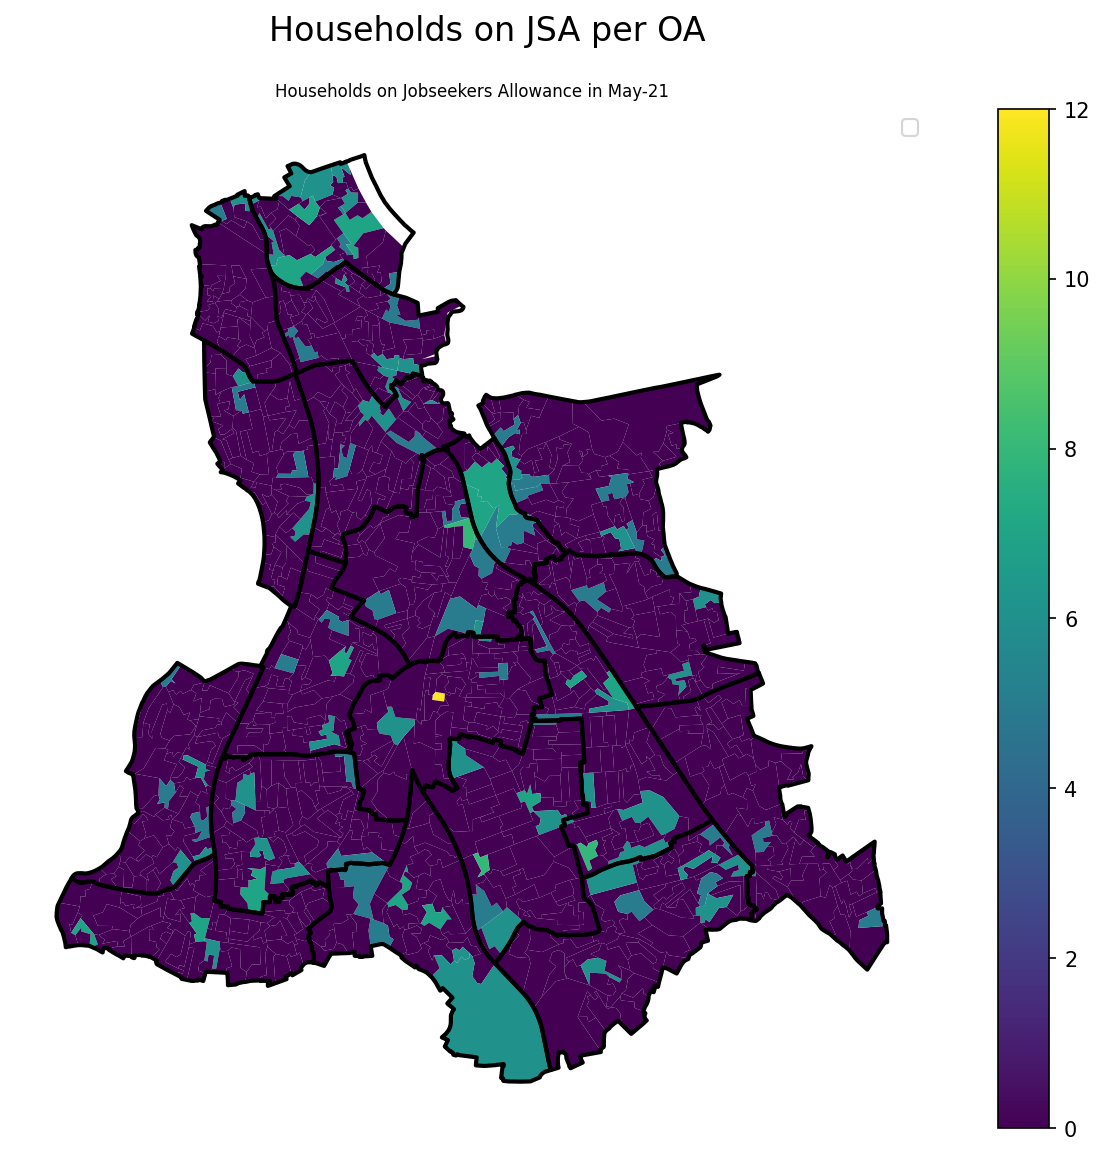

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Households on JSA per OA', fontsize=16, y=.95)
plt.title('Households on Jobseekers Allowance in '+epoch[0], fontsize=8)
education_oa_geom.plot(ax=ax, column="Jobseekers Allowance", legend=True)
plt.legend()
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')

plt.axis('off')

plt.savefig(f"{output_dir}/lbl_oa11_jsa.png", dpi=600)
plt.savefig(f"{output_dir}/lbl_oa11_jsa.pdf")